# Building a neural network to predict Churn

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import preprocessing

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Importing datasets

In [2]:
X_train, y_train, X_test, y_test = pickle.load(open("desafio_1_data.pkl", 'rb'))

# Datasets ready to go into the neural networks!
# Data pre-processing is in the other notebook

In [3]:
X_train.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,DSL,NoInternetService,OneyearContract,TwoyearContract,BanktransferPay,CreditcardPay,MailedcheckPay,tenure_n,MonthlyCharges_n,TotalCharges_n,monthly_sobre_total_n,Cant_productos_n,Cant_productos_internet_n,MonthlyCharges_d2_0,MonthlyCharges_d2_1,MonthlyCharges_d2_2,TotalCharges_d2_0,TotalCharges_d2_1,TotalCharges_d2_2,TotalCharges_d2_3,TotalCharges_d2_4,TotalCharges_d2_5,TotalCharges_d2_6,TotalCharges_d2_7,tenure_d2_0,tenure_d2_1,tenure_d2_2,tenure_d2_3,tenure_d2_4,tenure_d2_5,tenure_d2_6,tenure_d2_7
count,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4.711000e+03,4.711000e+03,4.711000e+03,4.711000e+03,4.711000e+03,4.711000e+03,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000
mean,0.487370,0.161961,0.481851,0.298026,0.901083,0.416472,0.288262,0.348334,0.344725,0.288686,0.386118,0.391849,0.593292,0.344301,0.218425,0.210359,0.242411,0.209934,0.220972,0.226491,4.562496e-17,1.659089e-16,-3.469005e-17,-5.278921e-18,-7.239663e-17,1.176445e-16,0.200382,0.399703,0.399915,0.100616,0.099554,0.099979,0.099979,0.199958,0.099979,0.199958,0.099979,0.116960,0.093611,0.104224,0.093611,0.192953,0.205901,0.097856,0.094884
std,0.499894,0.368454,0.499724,0.457439,0.298583,0.493026,0.453002,0.476493,0.475329,0.453200,0.486910,0.488215,0.491272,0.475190,0.413221,0.407607,0.428587,0.407305,0.414946,0.418605,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,0.400329,0.489889,0.489933,0.300851,0.299437,0.300004,0.300004,0.400011,0.300004,0.400011,0.300004,0.321407,0.291317,0.305584,0.291317,0.394658,0.404401,0.297151,0.293086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.274391e+00,-1.541340e+00,-9.964857e-01,-5.144577e-01,-1.466687e+00,-1.112415e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.494104e-01,-9.758785e-01,-8.286698e-01,-4.960046e-01,-1.466687e+00,-1.112415e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.369580e-01,1.874268e-01,-3.909644e-01,-4.345622e-01,6.818088e-01,-2.605782e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.598528e-01,8.367522e-01,6.533569e-01,-1.445206e-01,6.818088e-01,5.171209e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000

# Defining functions to build models and to create visualizations

In [18]:
def build_model(name='Basic model', layers=(64,), 
                optimizer='rmsprop', 
                metric = keras.metrics.binary_accuracy,
                kernel_regularizer='l1',
                dropout=None,
                batch_normalization=None):

    if optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop()

    if kernel_regularizer == 'l1':
        kernel_regularizer=keras.regularizers.l1(0.01)
    #Initialization. Name based on input
    model  = Sequential(name=name)
    
    #Hidden layers: based on input
    for i,l in enumerate(layers):
        if i == 0:
            model.add(Dense(l, activation='relu', input_shape=(X_train.shape[1],)))
            continue
        if batch_normalization is not None:
            model.add(Dense(l))
            model.add(BatchNormalization())
            model.add(Activation(batch_normalization))
            continue
        model.add(Dense(l, activation='relu',kernel_regularizer=kernel_regularizer))
        if dropout is not None:
            model.add(Dropout(dropout))
    
    #Final layer: Binary classifier --> 1 neuron, sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    
    #Compilation: Optimizer based on input; Binary classifier --> binary crossentropy loss function
    model.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy, metrics=[metric])
    
    return model

def plot_history(history, metrics=['loss','binary_accuracy'], plot_val=True):
    if not isinstance(history, list):
        history = [history]
    if not isinstance(metrics, list):
        metrics = [metrics]
    
    fig, ax = plt.subplots(1,len(metrics),figsize=(14,6))
    fig.suptitle(history[0].model.name)
    for h in history:
        vars_to_plot = []
        for m in metrics:
            metric = dict(name=m, train=h.history[m])
            if plot_val:
                metric['val'] = h.history[f'val_{m}']
            vars_to_plot.append(metric)
        epochs = range(1, len(vars_to_plot[0]['train']) + 1)
        
        for idx, var in enumerate(vars_to_plot):
        
            ax[idx].set_title(var['name'])
            #ax[idx].set_xticks(ticks=epochs)
            ax[idx].set_ylabel(var['name'])
        
            ax[idx].plot(epochs, var['train'])
            if plot_val:
                ax[idx].plot(epochs, var['val'])
            ax[idx].legend([l +' ' + var['name'] for l in ['train', 'val']])
            
def compare_histories(histories, metrics=['loss','binary_accuracy','val_loss','val_binary_accuracy']):
    if not isinstance(metrics, list):
        metrics = [metrics]
        
    epochs = range(1, len(histories[0].history[metrics[0]]) + 1) 
    fig, ax = plt.subplots(1,len(metrics),figsize=(14,6))
    fig.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    fig.suptitle('Comparisons')
    for idx, m in enumerate(metrics):
        ax[idx].set_title(m)
        #ax[idx].set_xticks(ticks=epochs)
        #ax[idx].set_ylabel(m)
        for history in histories:
            ax[idx].plot(epochs, history.history[m])
        if idx == 0:
            ax[idx].legend([history.model.name for history in histories])

# Splitting train and validation datasets

In [14]:
from sklearn.model_selection import train_test_split

partial_train_data, val_data, partial_train_targets, val_targets = train_test_split(X_train, y_train, 
                                                                                    test_size=0.33, random_state=42)

# We will use L1 regularization for this notebook

# Testing different architectures

## Using GridSearchCV

In [19]:
import itertools
# Definimos la "grilla" de parámetros que vamos a explorar
layers_to_test = [1,2,3,4]
neurons_per_layer_to_test = [2, 4, 8, 16, 32, 64, 128, 256]
architecture_combinations = []
for l in layers_to_test:
    for n in neurons_per_layer_to_test:
        combination = [n for x in range(l)]
        architecture_combinations.append(tuple(combination))

In [20]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

wrapper = KerasClassifier(build_model, batch_size=16, epochs=20, verbose=0)

params = {'layers': architecture_combinations}
grid = GridSearchCV(wrapper, params, cv=5,  scoring = 'f1')
grid.fit(partial_train_data, partial_train_targets,
         validation_data=(val_data, val_targets),
         batch_size=16, epochs=20, verbose=0)
print(grid.best_score_.round(2))
print('Best model architecture:', grid.best_estimator_.get_params()['layers'])

0.6
Best model architecture: (64, 64)


## Manually testing some architectures in detail

In [21]:
model_templates = [dict(name='2x32', 
                       layers=(32,32), 
                       optimizer=keras.optimizers.RMSprop(), 
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy),
                  dict(name='2x64', 
                       layers=(64, 64), 
                       optimizer=keras.optimizers.RMSprop(),  
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy),
                  dict(name='2x128', 
                       layers=(128,128), 
                       optimizer=keras.optimizers.RMSprop(), 
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy)]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [22]:
histories_base = []
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=20, batch_size=8,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_base.append(history)

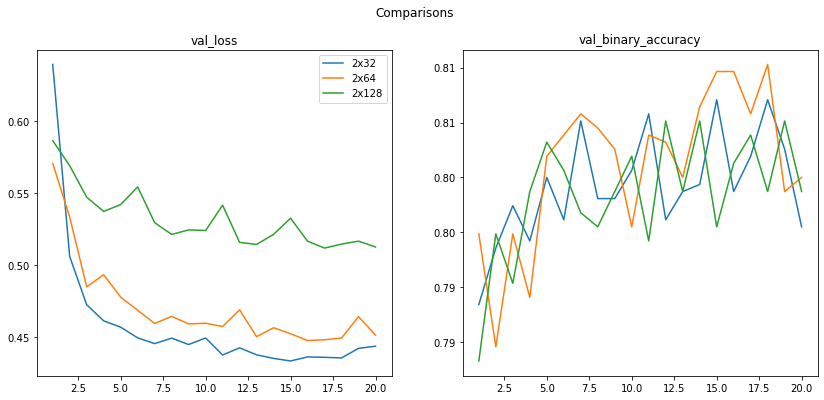

In [23]:
compare_histories(histories_base, metrics=['val_loss','val_binary_accuracy'])

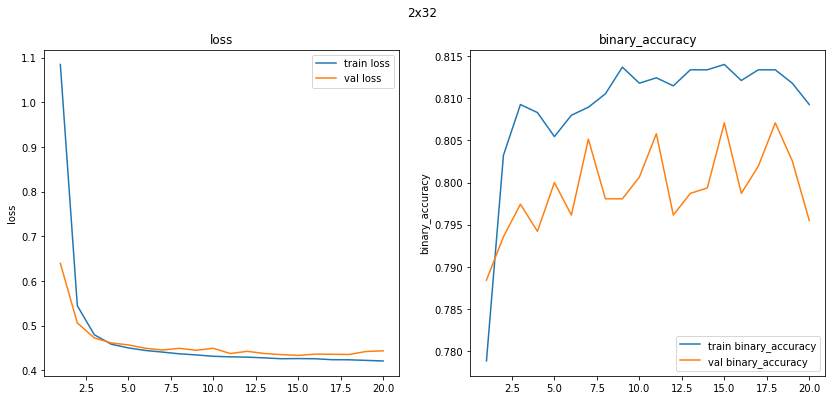

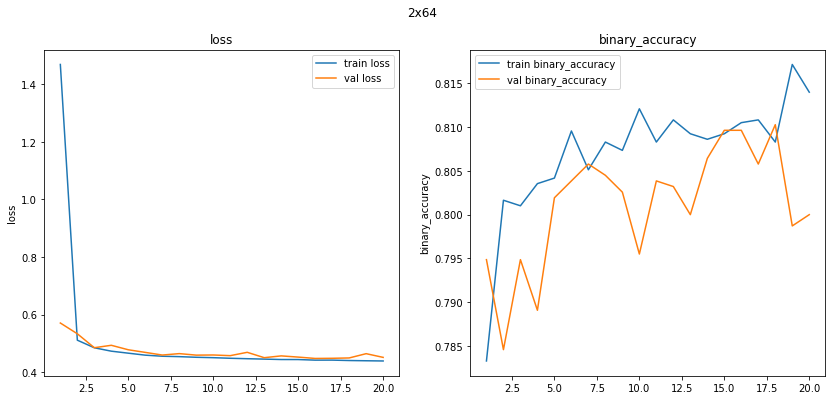

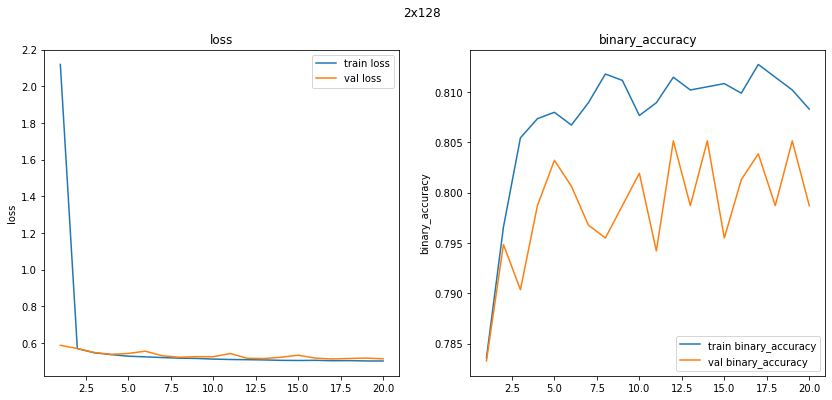

In [24]:
for history in histories_base:
    plot_history(history)

# Base model: 2x64

In [25]:
selected_model_base = histories_base[1]
selected_model_base.model.summary()

Model: "2x64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1464 (Dense)           (None, 64)                2944      
_________________________________________________________________
dense_1465 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1466 (Dense)           (None, 1)                 65        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________


# Dropout

In [26]:
wrapper = KerasClassifier(build_model, layers=(64,64), kernel_regularizer='l1',
                          batch_size=16, epochs=20, verbose=0)
dropout_rates_to_test = [0, 0.1, 0.5, 1, 2, 5]
params = {'dropout': dropout_rates_to_test}
grid = GridSearchCV(wrapper, params, cv=5,  scoring = 'f1')
grid.fit(partial_train_data, partial_train_targets,
         validation_data=(val_data, val_targets),
         batch_size=16, epochs=20, verbose=0)
print(grid.best_score_.round(2))
print('Best model dropout rate:', grid.best_estimator_.get_params()['dropout'])

0.59
Best model dropout rate: 0.5


# GridsearchCV selected dropout_rate = 0.5
# Comparing it with model without dropout

In [27]:
model_templates = [dict(name='2x64 dropout 0.5', 
                       layers=(64,64),  
                       metric=keras.metrics.binary_accuracy,
                       kernel_regularizer='l1',
                       dropout=0.5),]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [29]:
histories_dropout = [selected_model_base]
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=20, batch_size=8,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_dropout.append(history)

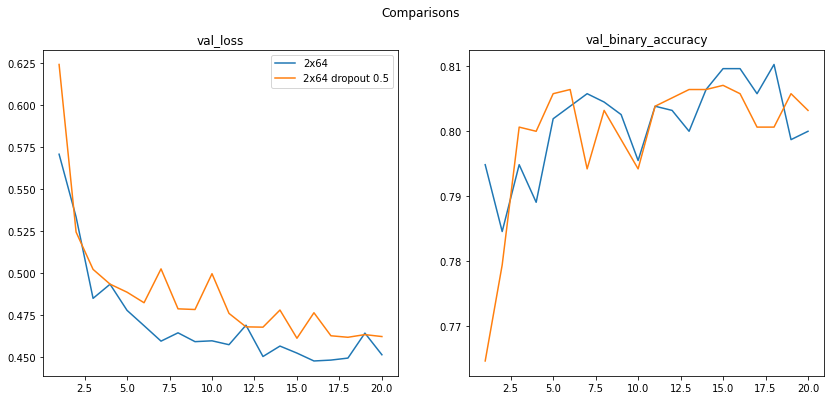

In [30]:
compare_histories(histories_dropout, metrics=['val_loss','val_binary_accuracy'])

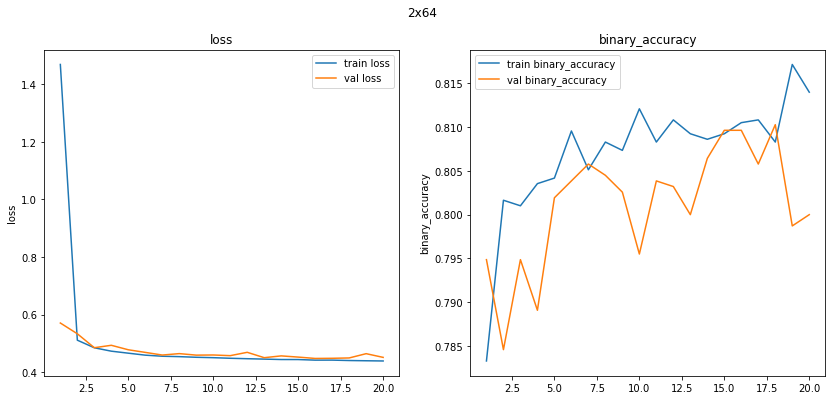

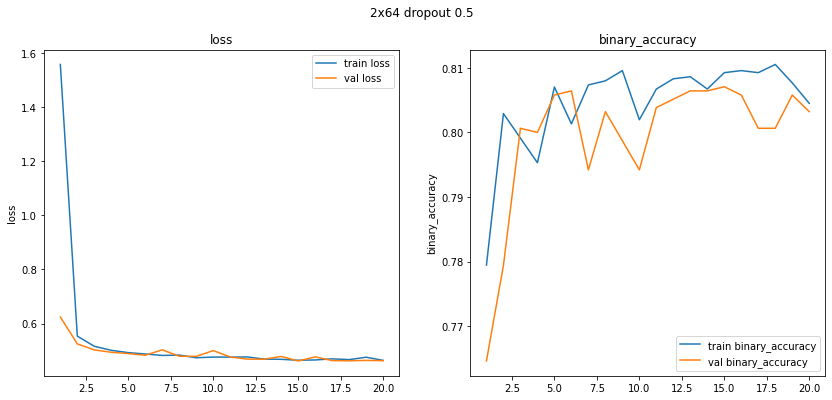

In [31]:
for history in histories_dropout:
    plot_history(history)

# Let's use Dropout 0.5

In [32]:
selected_dropout_model = histories_dropout[1]
selected_dropout_model.model.summary()

Model: "2x64 dropout 0.5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1563 (Dense)           (None, 64)                2944      
_________________________________________________________________
dense_1564 (Dense)           (None, 64)                4160      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1565 (Dense)           (None, 1)                 65        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________


# Optimizers

In [48]:
model_templates = [dict(name='2x64 dropout 0.5 SGD', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False), 
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy,
                       dropout=0.5),
                   dict(name='2x64 dropout 0.5 SGD + Momentum', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy,
                       dropout=0.5),
                   dict(name='2x64 dropout 0.5 SGD + Momentum + Nesterov', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy,
                       dropout=0.5),
                  dict(name='2x64 dropout 0.5 Adam', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy,
                       dropout=0.5),
                  dict(name='2x64 SGD', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False), 
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy),
                   dict(name='2x64 SGD + Momentum', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy),
                   dict(name='2x64 SGD + Momentum + Nesterov', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy),
                  dict(name='2x64 Adam', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy)]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [49]:
histories_optimizers = [selected_model_base, selected_dropout_model]
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=20, batch_size=16,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_optimizers.append(history)

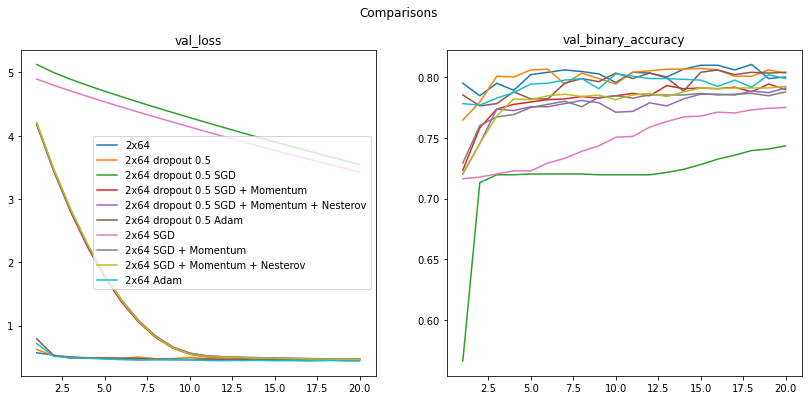

In [50]:
compare_histories(histories_optimizers, metrics=['val_loss','val_binary_accuracy'])

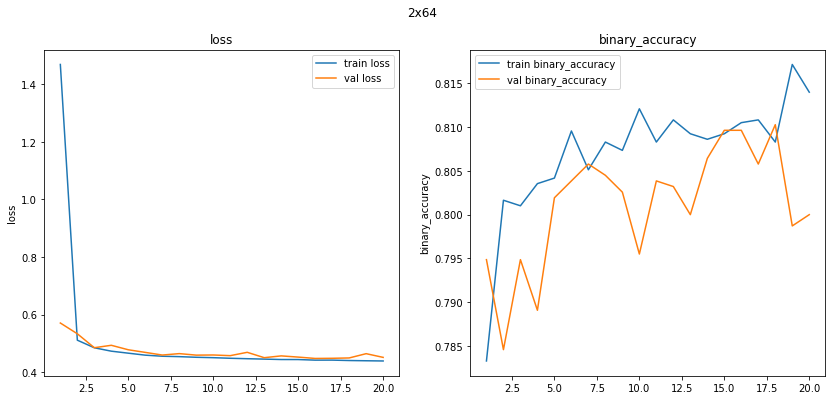

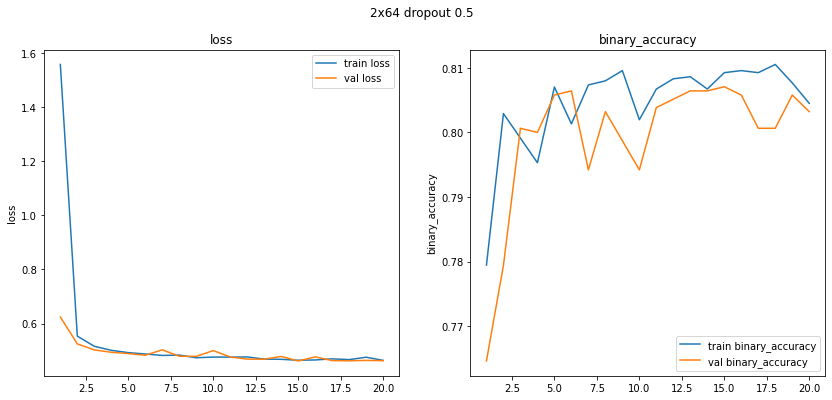

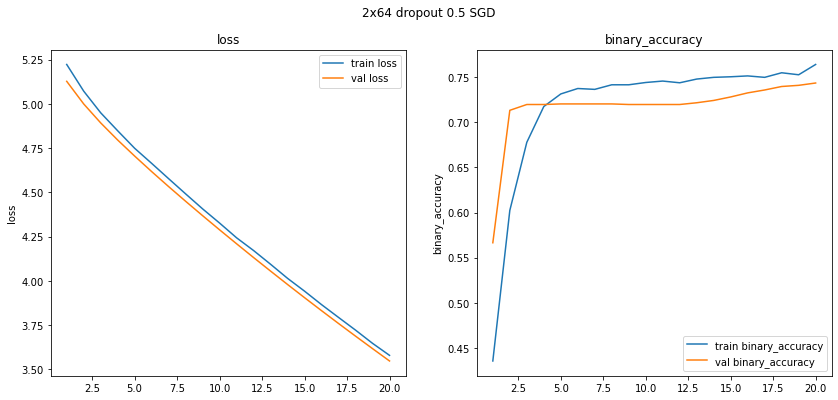

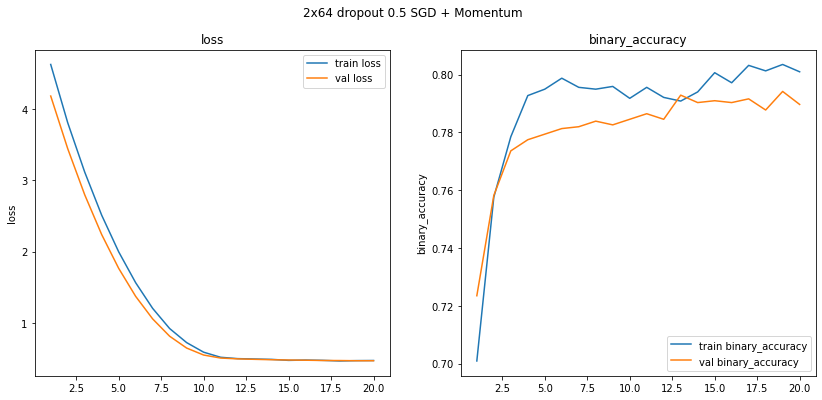

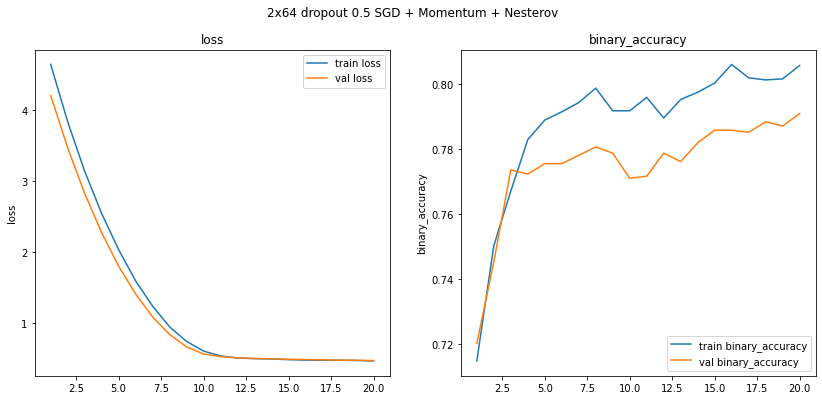

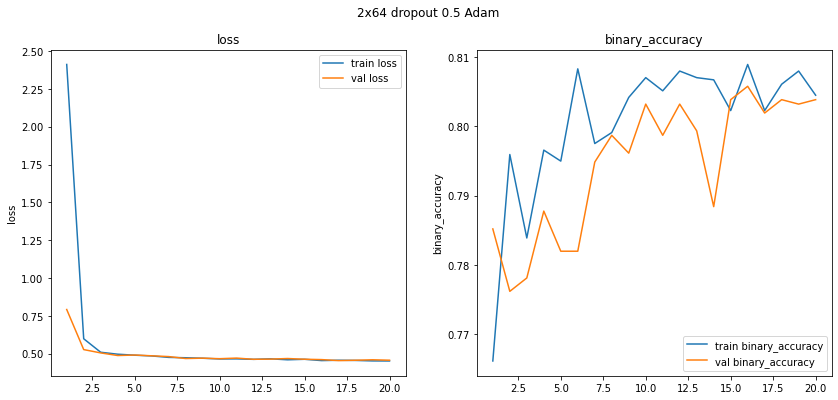

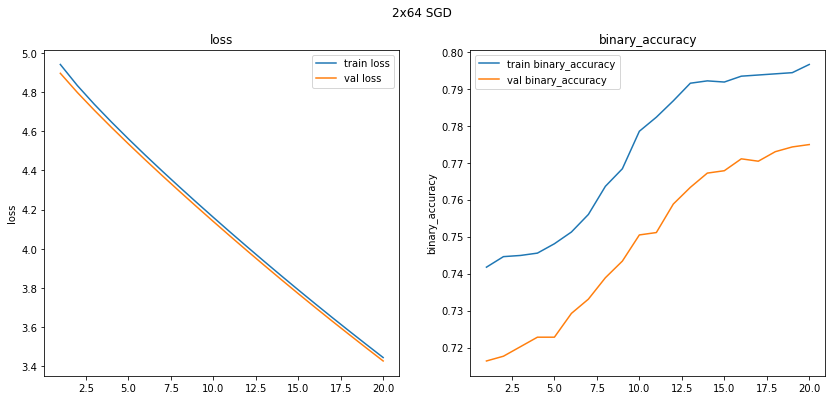

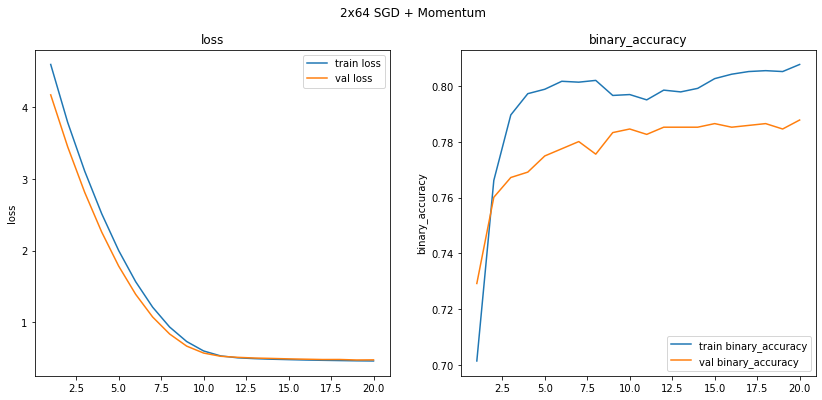

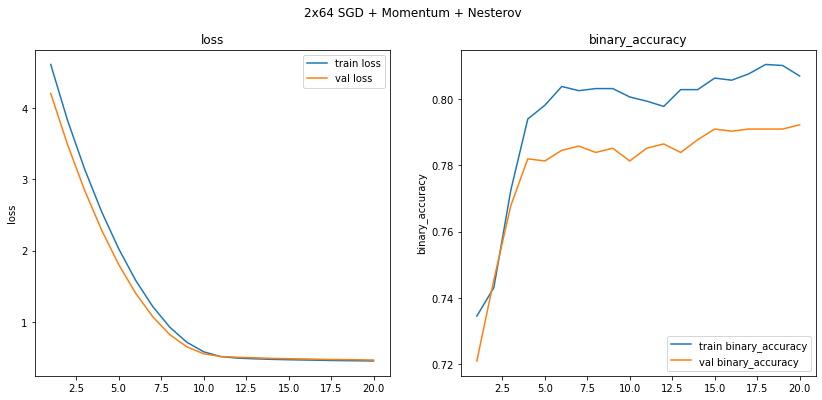

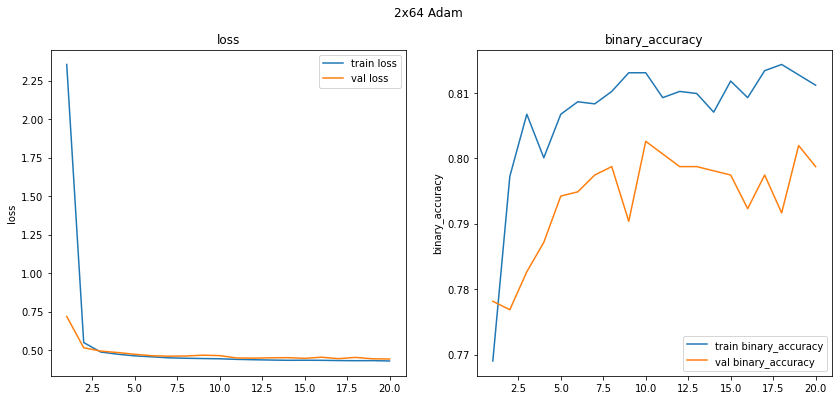

In [51]:
for history in histories_optimizers:
    plot_history(history)

In [52]:
for h in histories_optimizers:
    print(f"{round(max(h.history['val_binary_accuracy']),3)} max val_binary_accuracy - {h.model.name}")

0.81 max val_binary_accuracy - 2x64
0.807 max val_binary_accuracy - 2x64 dropout 0.5
0.743 max val_binary_accuracy - 2x64 dropout 0.5 SGD
0.794 max val_binary_accuracy - 2x64 dropout 0.5 SGD + Momentum
0.791 max val_binary_accuracy - 2x64 dropout 0.5 SGD + Momentum + Nesterov
0.806 max val_binary_accuracy - 2x64 dropout 0.5 Adam
0.775 max val_binary_accuracy - 2x64 SGD
0.788 max val_binary_accuracy - 2x64 SGD + Momentum
0.792 max val_binary_accuracy - 2x64 SGD + Momentum + Nesterov
0.803 max val_binary_accuracy - 2x64 Adam


In [53]:
for h in histories_optimizers:
    print(f"{round(min(h.history['val_loss']),3)} min val_loss - {h.model.name}")

0.448 min val_loss - 2x64
0.461 min val_loss - 2x64 dropout 0.5
3.547 min val_loss - 2x64 dropout 0.5 SGD
0.468 min val_loss - 2x64 dropout 0.5 SGD + Momentum
0.471 min val_loss - 2x64 dropout 0.5 SGD + Momentum + Nesterov
0.454 min val_loss - 2x64 dropout 0.5 Adam
3.427 min val_loss - 2x64 SGD
0.47 min val_loss - 2x64 SGD + Momentum
0.464 min val_loss - 2x64 SGD + Momentum + Nesterov
0.441 min val_loss - 2x64 Adam


# Adam lowers val_loss

In [56]:
selected_optimized_model = [histories_optimizers[5], histories_optimizers[9]]
for m in selected_optimized_model:
    m.model.summary()

Model: "2x64 dropout 0.5 Adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1599 (Dense)           (None, 64)                2944      
_________________________________________________________________
dense_1600 (Dense)           (None, 64)                4160      
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1601 (Dense)           (None, 1)                 65        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________
Model: "2x64 Adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1611 (Dense)           (None, 64)                2944      
________________________

# Batch normalization

In [59]:
from keras.layers import BatchNormalization, Activation

model_templates = [dict(name='2x64 dropout 0.5 RMSprop norm relu', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.RMSprop(),
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='relu',
                       dropout = 0.5),
                  dict(name='2x64 dropout 0.5 RMSprop norm sigmoid', 
                       layers=(64,64),  
                       optimizer=keras.optimizers.RMSprop(), 
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='sigmoid',
                       dropout = 0.5),
                  dict(name='2x64 dropout 0.5 Adam norm relu', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(), 
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='relu',
                       dropout = 0.5),
                  dict(name='2x64 dropout 0.5 Adam norm sigmoid', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(),
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='sigmoid',
                       dropout = 0.5),
                  dict(name='2x64 norm relu', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.RMSprop(),
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='relu'),
                  dict(name='2x64 RMSprop norm sigmoid', 
                       layers=(64,64),  
                       optimizer=keras.optimizers.RMSprop(), 
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='sigmoid'),
                  dict(name='2x64 Adam norm relu', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(), 
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='relu'),
                  dict(name='2x64 Adam norm sigmoid', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(),
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='sigmoid')]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [60]:
histories_normalization = [selected_model_base, selected_dropout_model] + selected_optimized_model
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=20, batch_size=8,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_normalization.append(history)

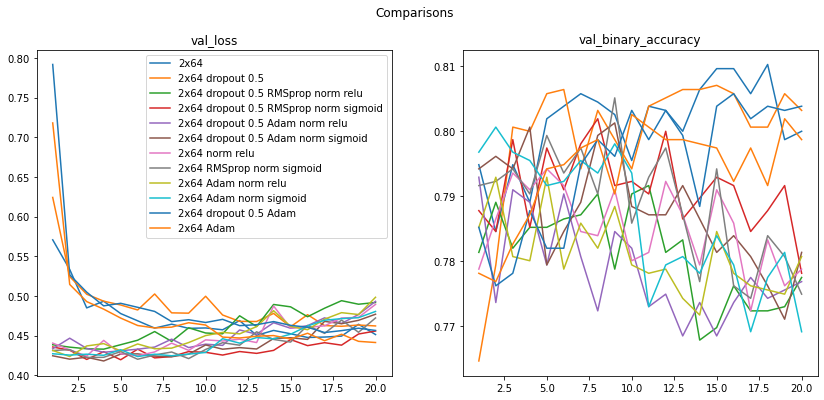

In [64]:
compare_histories(histories_normalization, metrics=['val_loss','val_binary_accuracy'])

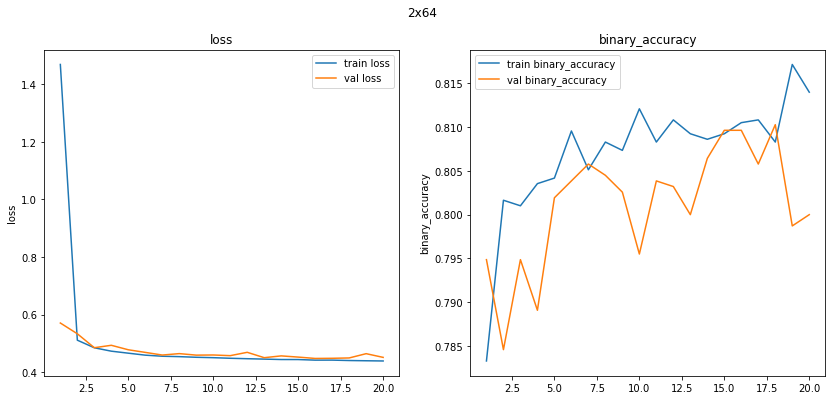

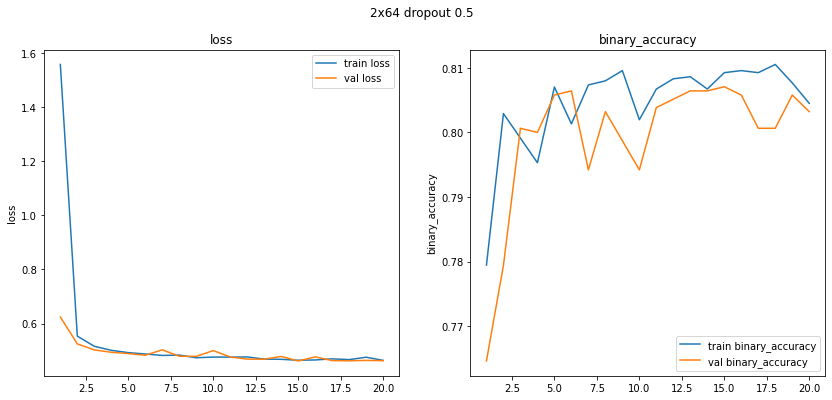

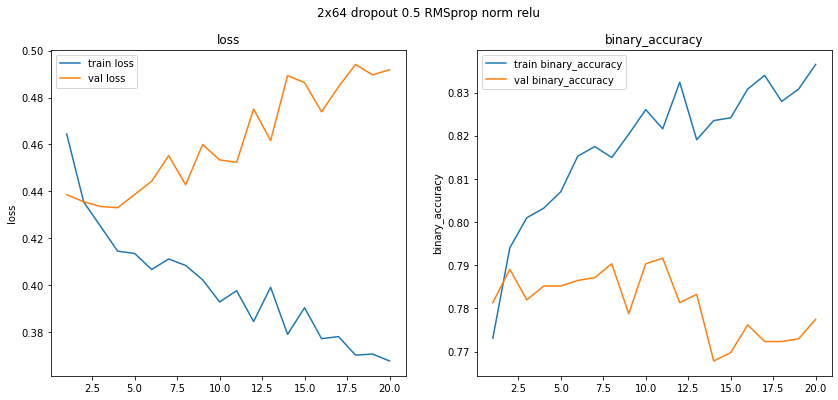

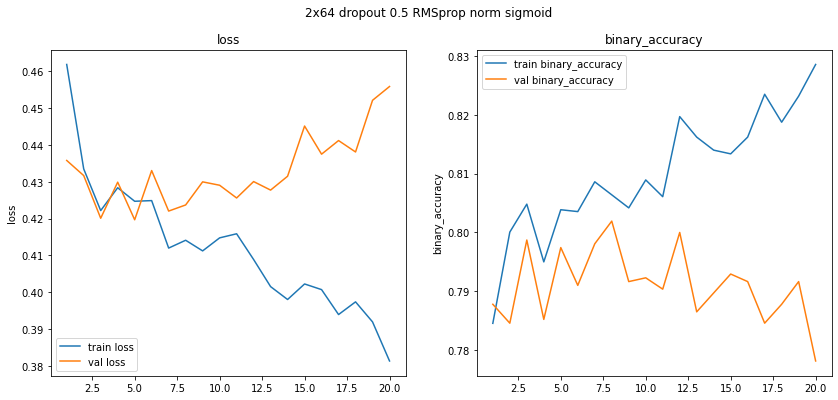

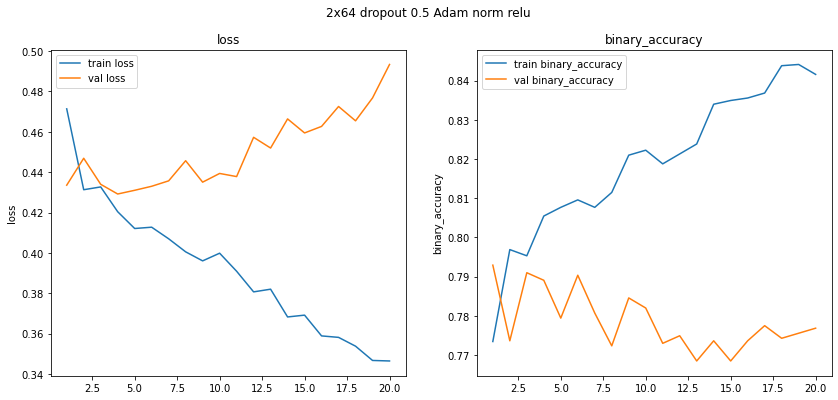

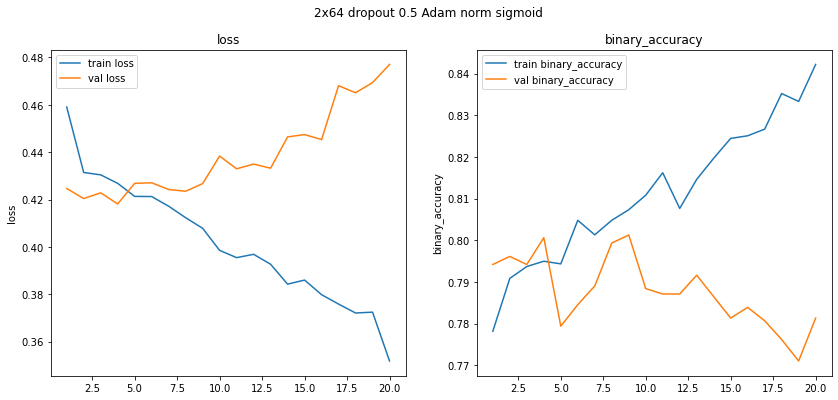

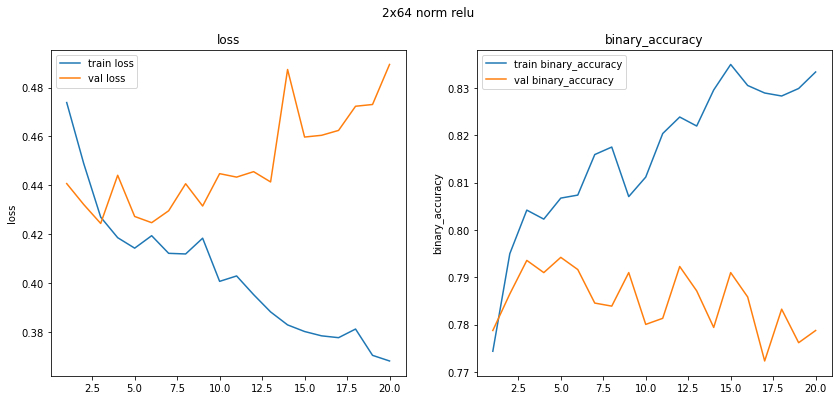

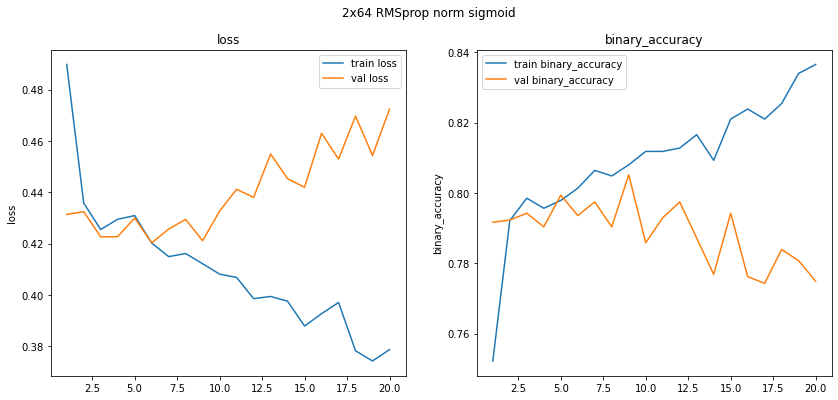

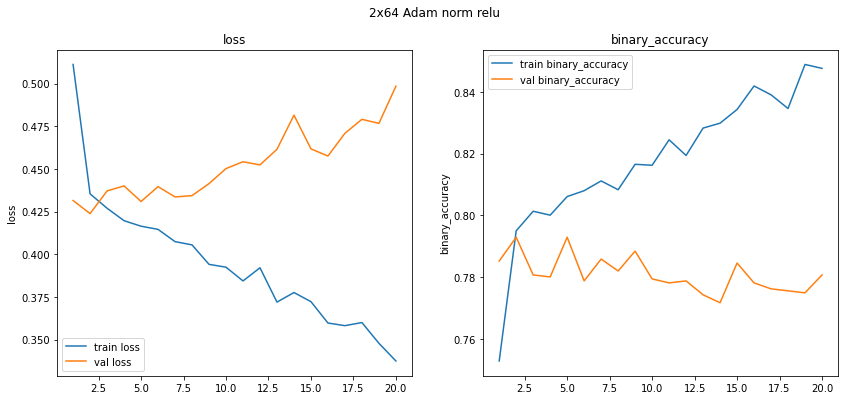

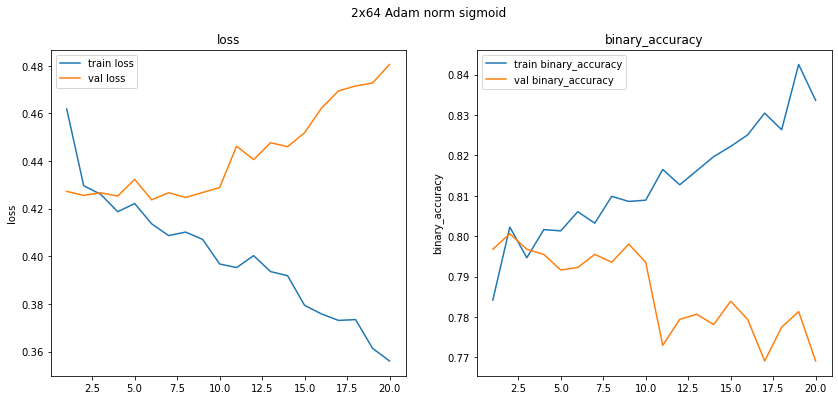

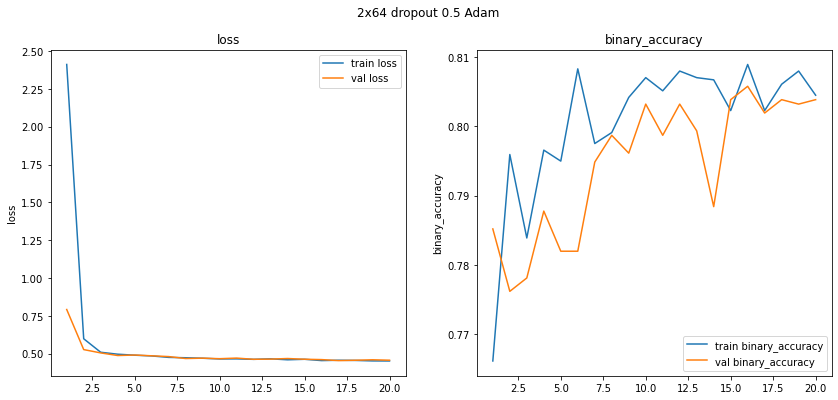

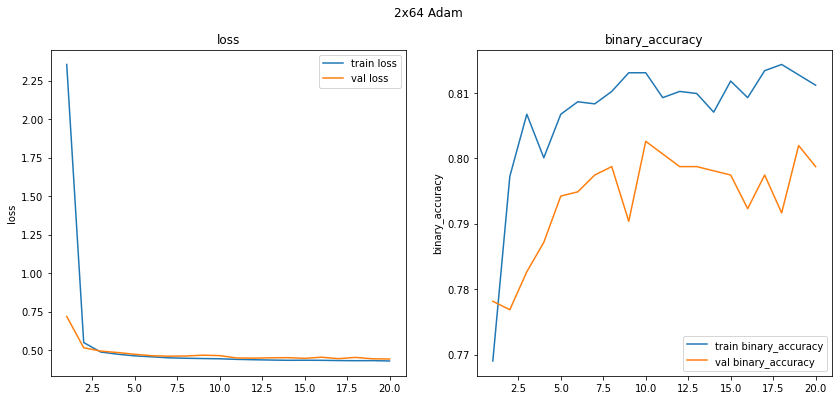

In [65]:
for history in histories_normalization:
    plot_history(history)

# In this case, normalization causes overfitting

# Early stopping and ReduceLROnPlateau

In [70]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

# Training best models

In [68]:
for h in [selected_model_base, selected_dropout_model] + selected_optimized_model:
    print(h.model.name)

2x64
2x64 dropout 0.5
2x64 dropout 0.5 Adam
2x64 Adam


# 2x64 performance

In [391]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1,
                                   save_best_only=True, save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
callbacks_list = [model_checkpoint, reduce_lr]
best_template = dict(name='2x64 L1 RMSprop',
                     layers=(64,64),  
                     kernel_regularizer='l1',
                     metric=keras.metrics.binary_accuracy)
model = build_model(**best_template)

history = model.fit(partial_train_data, partial_train_targets,
                    epochs=20, batch_size=8,
                    validation_data=(val_data, val_targets),
                    callbacks=callbacks_list)

Train on 3156 samples, validate on 1555 samples
Epoch 1/20
3156/3156 [==============================] - 1s 402us/step - loss: 1.4304 - binary_accuracy: 0.7830 - val_loss: 0.5666 - val_binary_accuracy: 0.7672

Epoch 00001: val_loss improved from inf to 0.56656, saving model to weights.01-0.57.hdf5
Epoch 2/20
3156/3156 [==============================] - 1s 323us/step - loss: 0.5114 - binary_accuracy: 0.8077 - val_loss: 0.5032 - val_binary_accuracy: 0.7794

Epoch 00002: val_loss improved from 0.56656 to 0.50318, saving model to weights.02-0.50.hdf5
Epoch 3/20
3156/3156 [==============================] - 1s 337us/step - loss: 0.4834 - binary_accuracy: 0.8096 - val_loss: 0.4937 - val_binary_accuracy: 0.8006

Epoch 00003: val_loss improved from 0.50318 to 0.49365, saving model to weights.03-0.49.hdf5
Epoch 4/20
3156/3156 [==============================] - 1s 389us/step - loss: 0.4722 - binary_accuracy: 0.8099 - val_loss: 0.4771 - val_binary_accuracy: 0.7942

Epoch 00004: val_loss improved fr

In [392]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 33us/step


In [393]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.44247035716678706; Train acc: 0.8085331916809082
Test loss: 0.456598272140249; Test acc: 0.7992244958877563


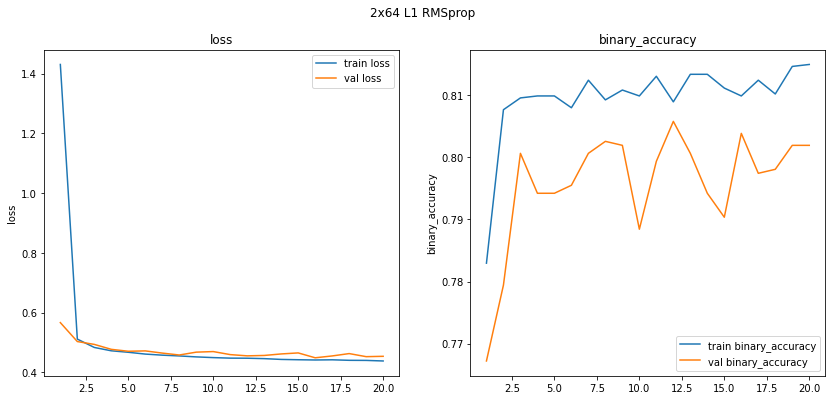

In [394]:
plot_history(history)

# Importing best weights generated by ModelCheckpoint

In [395]:
best_template =dict(name='2x64 L1 RMSprop',
                     layers=(64,64),  
                     kernel_regularizer='l1',
                     metric=keras.metrics.binary_accuracy)

model = build_model(**best_template)

# Testing initial weights to see enhancements

In [396]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 28us/step


In [397]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 5.06714348913479; Train acc: 0.6232222318649292
Test loss: 5.067666556289719; Test acc: 0.6281775236129761


# Loading ModelCheckpoint weights

In [407]:
model.load_weights('04-26-20 2015 2x64 L1 RMSprop weights.14-0.45.hdf5')

In [408]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 33us/step


In [409]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.44500709298663627; Train acc: 0.8117172718048096
Test loss: 0.4588077681581299; Test acc: 0.8009478449821472


In [368]:
model.summary()

Model: "2x64 L1 RMSprop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1752 (Dense)           (None, 64)                2944      
_________________________________________________________________
dense_1753 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1754 (Dense)           (None, 1)                 65        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________


# 2x64 dropout 0.5 performance

In [197]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1,
                                   save_best_only=True, save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
callbacks_list = [model_checkpoint, reduce_lr]
best_template = dict(name='2x64 L1 RMSprop',
                     layers=(64,64),  
                     kernel_regularizer='l1',
                     metric=keras.metrics.binary_accuracy,
                     dropout=0.5)
model = build_model(**best_template)

history = model.fit(partial_train_data, partial_train_targets,
                    epochs=20, batch_size=8,
                    validation_data=(val_data, val_targets),
                    callbacks=callbacks_list)

Train on 3156 samples, validate on 1555 samples
Epoch 1/20
3156/3156 [==============================] - 1s 472us/step - loss: 1.4933 - binary_accuracy: 0.7836 - val_loss: 0.5774 - val_binary_accuracy: 0.7884

Epoch 00001: val_loss improved from inf to 0.57742, saving model to weights.01-0.58.hdf5
Epoch 2/20
3156/3156 [==============================] - 1s 361us/step - loss: 0.5366 - binary_accuracy: 0.7975 - val_loss: 0.5177 - val_binary_accuracy: 0.7852

Epoch 00002: val_loss improved from 0.57742 to 0.51769, saving model to weights.02-0.52.hdf5
Epoch 3/20
3156/3156 [==============================] - 1s 361us/step - loss: 0.5085 - binary_accuracy: 0.7988 - val_loss: 0.4996 - val_binary_accuracy: 0.7910

Epoch 00003: val_loss improved from 0.51769 to 0.49960, saving model to weights.03-0.50.hdf5
Epoch 4/20
3156/3156 [==============================] - 1s 364us/step - loss: 0.5010 - binary_accuracy: 0.8026 - val_loss: 0.4924 - val_binary_accuracy: 0.8026

Epoch 00004: val_loss improved fr

In [198]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 35us/step


In [199]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.45009676574066526; Train acc: 0.8112927079200745
Test loss: 0.4654805542245501; Test acc: 0.7962085604667664


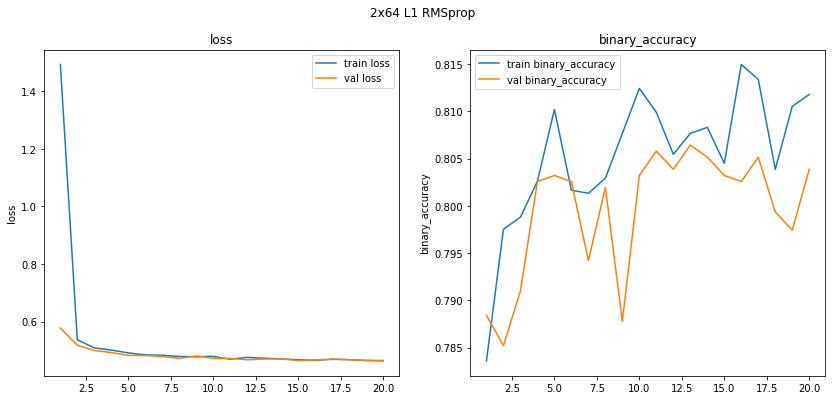

In [200]:
plot_history(history)

# Importing best weights generated by ModelCheckpoint

In [201]:
best_template =dict(name='2x64 L1 dropout 0.5 RMSprop',
                     layers=(64,64),  
                     kernel_regularizer='l1',
                     metric=keras.metrics.binary_accuracy,
                     dropout=0.5)

model = build_model(**best_template)

# Testing initial weights to see enhancements

In [202]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 35us/step


In [203]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 5.303453634205808; Train acc: 0.2872001826763153
Test loss: 5.308134770095477; Test acc: 0.27962085604667664


# Loading ModelCheckpoint weights

In [204]:
model.load_weights('04-26-20 2020 2x64 L1 dropout 0.5 RMSprop weights.12-0.47.hdf5')

In [205]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 40us/step


In [206]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.4550103734339708; Train acc: 0.8098068237304688
Test loss: 0.46852321048997075; Test acc: 0.7979319095611572


In [207]:
model.summary()

Model: "2x64 L1 dropout 0.5 RMSprop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1692 (Dense)           (None, 64)                2944      
_________________________________________________________________
dense_1693 (Dense)           (None, 64)                4160      
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1694 (Dense)           (None, 1)                 65        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________


# 2x64 dropout 0.5 Adam performance

In [230]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1,
                                   save_best_only=True, save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
callbacks_list = [model_checkpoint, reduce_lr]
best_template = dict(name='2x64 dropout 0.5 Adam', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(), 
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy,
                       dropout=0.5)
model = build_model(**best_template)

history = model.fit(partial_train_data, partial_train_targets,
                    epochs=20, batch_size=8,
                    validation_data=(val_data, val_targets),
                    callbacks=callbacks_list)

Train on 3156 samples, validate on 1555 samples
Epoch 1/20
3156/3156 [==============================] - 2s 483us/step - loss: 1.6623 - binary_accuracy: 0.7741 - val_loss: 0.6003 - val_binary_accuracy: 0.7878

Epoch 00001: val_loss improved from inf to 0.60030, saving model to weights.01-0.60.hdf5
Epoch 2/20
3156/3156 [==============================] - 1s 380us/step - loss: 0.5342 - binary_accuracy: 0.7950 - val_loss: 0.5126 - val_binary_accuracy: 0.7775

Epoch 00002: val_loss improved from 0.60030 to 0.51263, saving model to weights.02-0.51.hdf5
Epoch 3/20
3156/3156 [==============================] - 1s 394us/step - loss: 0.5034 - binary_accuracy: 0.8001 - val_loss: 0.4958 - val_binary_accuracy: 0.7936

Epoch 00003: val_loss improved from 0.51263 to 0.49578, saving model to weights.03-0.50.hdf5
Epoch 4/20
3156/3156 [==============================] - 1s 362us/step - loss: 0.4884 - binary_accuracy: 0.8007 - val_loss: 0.4956 - val_binary_accuracy: 0.7897

Epoch 00004: val_loss improved fr

In [231]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 33us/step


In [232]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.436909875642517; Train acc: 0.8087455034255981
Test loss: 0.45042083665041616; Test acc: 0.7992244958877563


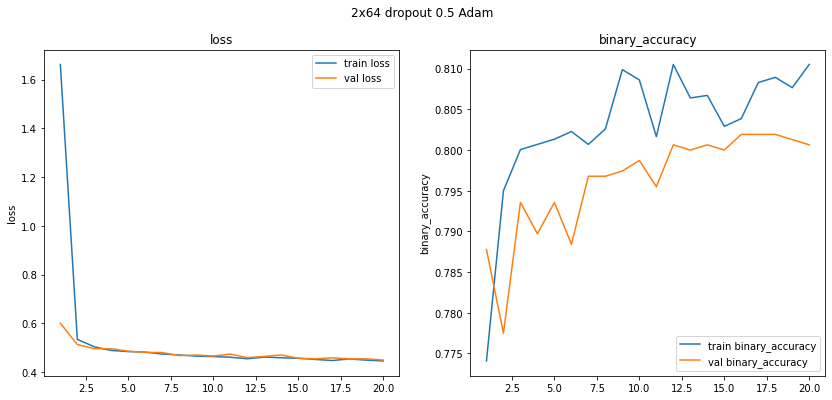

In [233]:
plot_history(history)

# Importing best weights generated by ModelCheckpoint

In [234]:
best_template =dict(name='2x64 dropout 0.5 Adam', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(), 
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy,
                       dropout=0.5)

model = build_model(**best_template)

# Testing initial weights to see enhancements

In [235]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 33us/step


In [236]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 5.0917873767196085; Train acc: 0.7117384672164917
Test loss: 5.091843580182695; Test acc: 0.7087462544441223


# Loading ModelCheckpoint weights

In [237]:
model.load_weights('04-26-20 2024 2x64 dropout 0.5 Adam weights.16-0.45.hdf5')

In [238]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 33us/step


In [239]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.43838760235258484; Train acc: 0.8108682036399841
Test loss: 0.45216748002837925; Test acc: 0.7979319095611572


In [240]:
model.summary()

Model: "2x64 dropout 0.5 Adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1704 (Dense)           (None, 64)                2944      
_________________________________________________________________
dense_1705 (Dense)           (None, 64)                4160      
_________________________________________________________________
dropout_52 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1706 (Dense)           (None, 1)                 65        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________


# 2x64 Adam

In [280]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1,
                                   save_best_only=True, save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
callbacks_list = [model_checkpoint, reduce_lr]
best_template = dict(name='2x64 Adam', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(), 
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy)
model = build_model(**best_template)

history = model.fit(partial_train_data, partial_train_targets,
                    epochs=20, batch_size=8,
                    validation_data=(val_data, val_targets),
                    callbacks=callbacks_list)

Train on 3156 samples, validate on 1555 samples
Epoch 1/20
3156/3156 [==============================] - 2s 504us/step - loss: 1.5933 - binary_accuracy: 0.7934 - val_loss: 0.5481 - val_binary_accuracy: 0.7839

Epoch 00001: val_loss improved from inf to 0.54811, saving model to weights.01-0.55.hdf5
Epoch 2/20
3156/3156 [==============================] - 1s 368us/step - loss: 0.5063 - binary_accuracy: 0.8032 - val_loss: 0.5025 - val_binary_accuracy: 0.7974

Epoch 00002: val_loss improved from 0.54811 to 0.50248, saving model to weights.02-0.50.hdf5
Epoch 3/20
3156/3156 [==============================] - 1s 359us/step - loss: 0.4794 - binary_accuracy: 0.8105 - val_loss: 0.4811 - val_binary_accuracy: 0.7955

Epoch 00003: val_loss improved from 0.50248 to 0.48109, saving model to weights.03-0.48.hdf5
Epoch 4/20
3156/3156 [==============================] - 1s 362us/step - loss: 0.4681 - binary_accuracy: 0.8080 - val_loss: 0.4759 - val_binary_accuracy: 0.7961

Epoch 00004: val_loss improved fr

In [281]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 35us/step


In [282]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.4291611606972002; Train acc: 0.8068350553512573
Test loss: 0.44082916043586434; Test acc: 0.7953468561172485


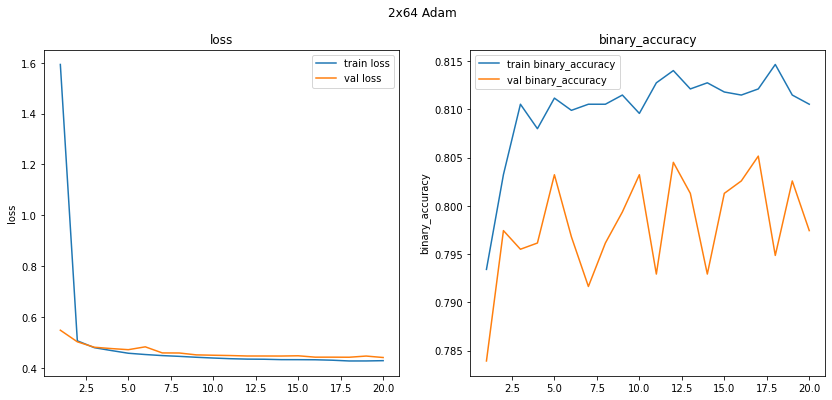

In [283]:
plot_history(history)

# Importing best weights generated by ModelCheckpoint

In [284]:
best_template = dict(name='2x64 Adam', 
                       layers=(64,64), 
                       optimizer=keras.optimizers.Adam(), 
                       kernel_regularizer='l1',
                       metric=keras.metrics.binary_accuracy)

model = build_model(**best_template)

# Testing initial weights to see enhancements

In [285]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 34us/step


In [286]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 5.13565266701705; Train acc: 0.45319464802742004
Test loss: 5.1372299769581105; Test acc: 0.45196035504341125


# Loading ModelCheckpoint weights

In [287]:
model.load_weights('04-26-20 2039 2x64 Adam weights.11-0.44.hdf5')

In [288]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 38us/step


In [289]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.4328994156827949; Train acc: 0.8112927079200745
Test loss: 0.44458282269932287; Test acc: 0.7996553182601929


In [290]:
model.summary()

Model: "2x64 Adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1719 (Dense)           (None, 64)                2944      
_________________________________________________________________
dense_1720 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1721 (Dense)           (None, 1)                 65        
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________


# Thanks!